In [38]:
import sys
sys.path.insert(0,'/home/noah/Desktop/large_analysis/ca_analysis/')
from matplotlib.pyplot import*
from scipy.optimize import curve_fit
import fileread as fr
import predefined as pd
import wave_ops as wo
import time
import numpy as np
import os

def calibrate(energy_type,board,channel): 
    bdch=int(board*8+channel) 
    if bdch ==6: 
        m,b=1/6.28,3.46 
    elif bdch==11: 
        m,b=1/6.43,-10.1 
    elif bdch==35: 
        m,b=1/6.18,43.7 
    elif bdch==12: 
        m,b=1/6.24,-21.82 
    else: 
        m,b=0,0   
    return (energy_type+b)*m  
vec_calibrate=np.vectorize(calibrate)

#sim=fr.simulation('/home/noah/Desktop/large_analysis/zeck_simulation/45Caaf.txt')
#sim=pd.sim_comb_single_pixel(sim)

path='/home/noah/Desktop/large_analysis/ca_analysis/falltimes/'
run=120
data=fr.gen_output(path+'Run_120-all.dat')[0]
data=data[pd.good_timestamps(data)]
data.sort(order='timestamp')
fs=35

In [20]:
beg=time.time()
energy_type='energy'
twindow=170
dummy='''trutharray=np.zeros(len(data))
for i in [11,12,35]:
    bd,ch=int(i/8),int(i%8)
    trutharray=pd.lor(trutharray,\
                pd.land(data['board']==bd,data['channel']==ch))'''

multi=data.copy()
multi[energy_type]=vec_calibrate(multi[energy_type],multi['board'],multi['channel'])
#multi=multi[multi[energy_type]>15]
multi=multi[multi[energy_type]<300]
multi=multi[pd.lor(multi['pileup']<2,np.abs(multi['pilediff'])<twindow)]
multi=multi[multi['t0']>600]
multi.sort(order='timestamp')
multi=multi[pd.doubles(multi,energy_type)]
print(time.time()-beg)

i,j=0,0
while i<len(multi)-1 and j<len(multi)-1:
    j=i+1
    backscattering=multi['timestamp'][j]-multi['timestamp'][i] < twindow
    energy=multi[energy_type][i]
    while backscattering and j<len(multi)-1:
        energy+=multi[energy_type][j]
        multi[energy_type][j]=-10
        j+=1
        backscattering=multi['timestamp'][j]-multi['timestamp'][i] < twindow
    multi[energy_type][i]=energy
    i=j
print(time.time()-beg)


475.4111406803131
500.69562673568726


/home/noah/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt


999.1461055471696 1.5232926414180092
1199.1291086295369 0.5970875601684533
1007.7979413087344 0.893876742475787


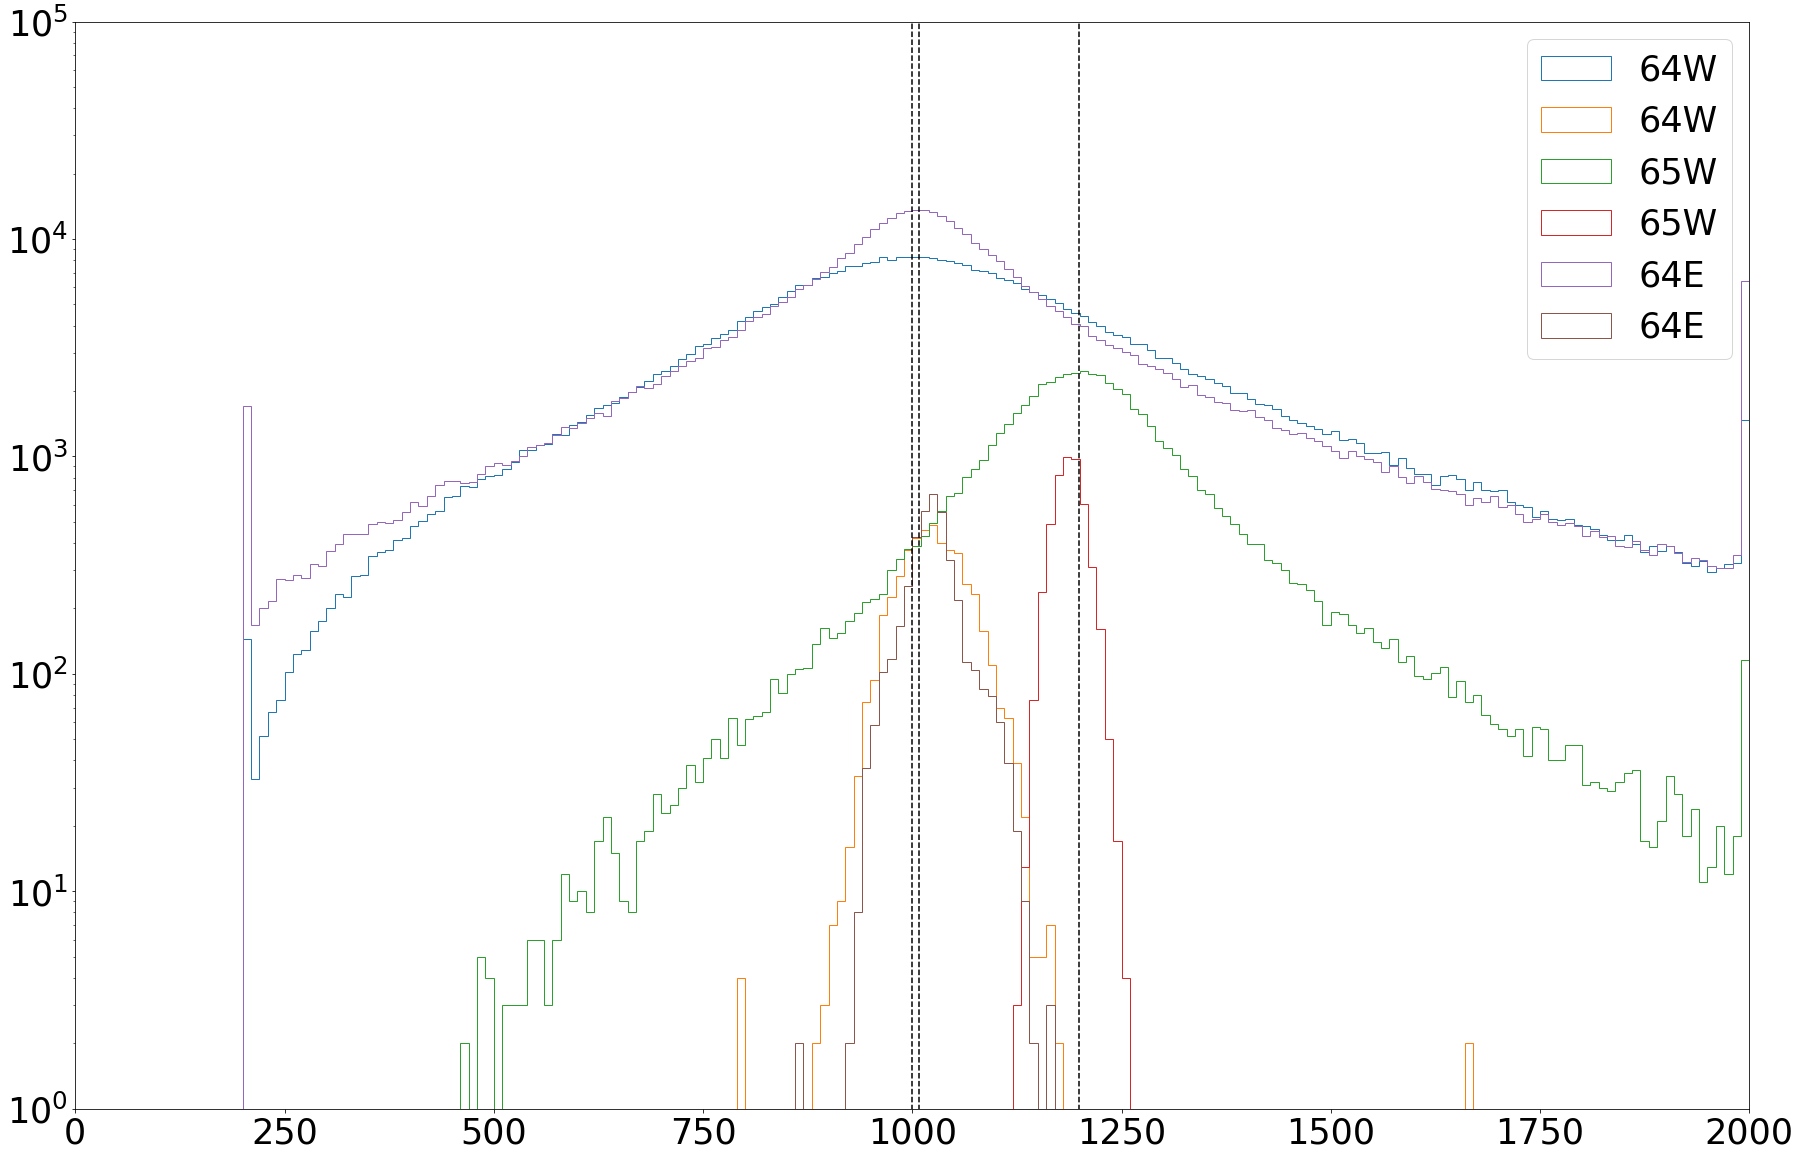

In [48]:
pulser=data[data['energy']>2000]
gauss=lambda t,a,mu,sigma: a*np.exp(-(t.astype('float')-mu)**2./(2.*sigma**2.))
fs=35
figure(figsize=(30,20))
beg,end=750,1500
for i in range(1,42):
    bd,ch=int(i/8),int(i%8)
    if pd.pixel(bd,ch) == 'Psr' or pd.pixel(bd,ch) == 'N/A':
        continue

    if i == 11 or i==12 or i==35:
        a,b,c=hist(pd.single_pixel(multi,bd,ch)['falltime'],bins=500,\
                   range=[0,5000],histtype='step',label=pd.pixel(bd,ch))
        d,e,f=hist(pd.single_pixel(pulser,bd,ch)['falltime'],bins=500,\
                   range=[0,5000],histtype='step',label=pd.pixel(bd,ch))
        b=pd.cbins(b)
        fitbins=b[pd.land(b>beg,b<end)]
        fithist=a[pd.land(b>beg,b<end)]
        mu=fitbins[np.argmax(fithist)]
        
        fitbins=b[pd.land(b>mu-100,b<mu+100)]
        fithist=a[pd.land(b>mu-100,b<mu+100)]
        
        a=np.amax(fithist)
        sigma=20
        pars,vars=curve_fit(gauss,fitbins,fithist,p0=[a,mu,sigma],bounds=[0,np.inf])
        print (pars[1],np.diag(np.sqrt(vars))[1])
        plot((pars[1],pars[1]),(0,1e5),'k--')
    a,b=np.histogram(pd.single_pixel(multi,bd,ch)['falltime'],bins=500,range=[0,5000])
    b=pd.cbins(b)


legend(fontsize=fs)
tick_params(labelsize=fs)
xlim(0,2000)
ylim(1,1e5)
yscale('log')
show()

200 39W
200 40W
200 41W
200 50W
0 51W
200 52W
200 53W
200 62W
200 63W
2000 64W
1200 65W
200 66W
200 75W
200 76W
1120 77W
200 78W
200 87W
2000 88W
200 89W
200 39E
200 40E
200 41E
200 50E
200 51E
200 52E
200 53E
200 62E
200 63E
200 64E
200 65E
200 66E
200 75E
200 76E
200 77E


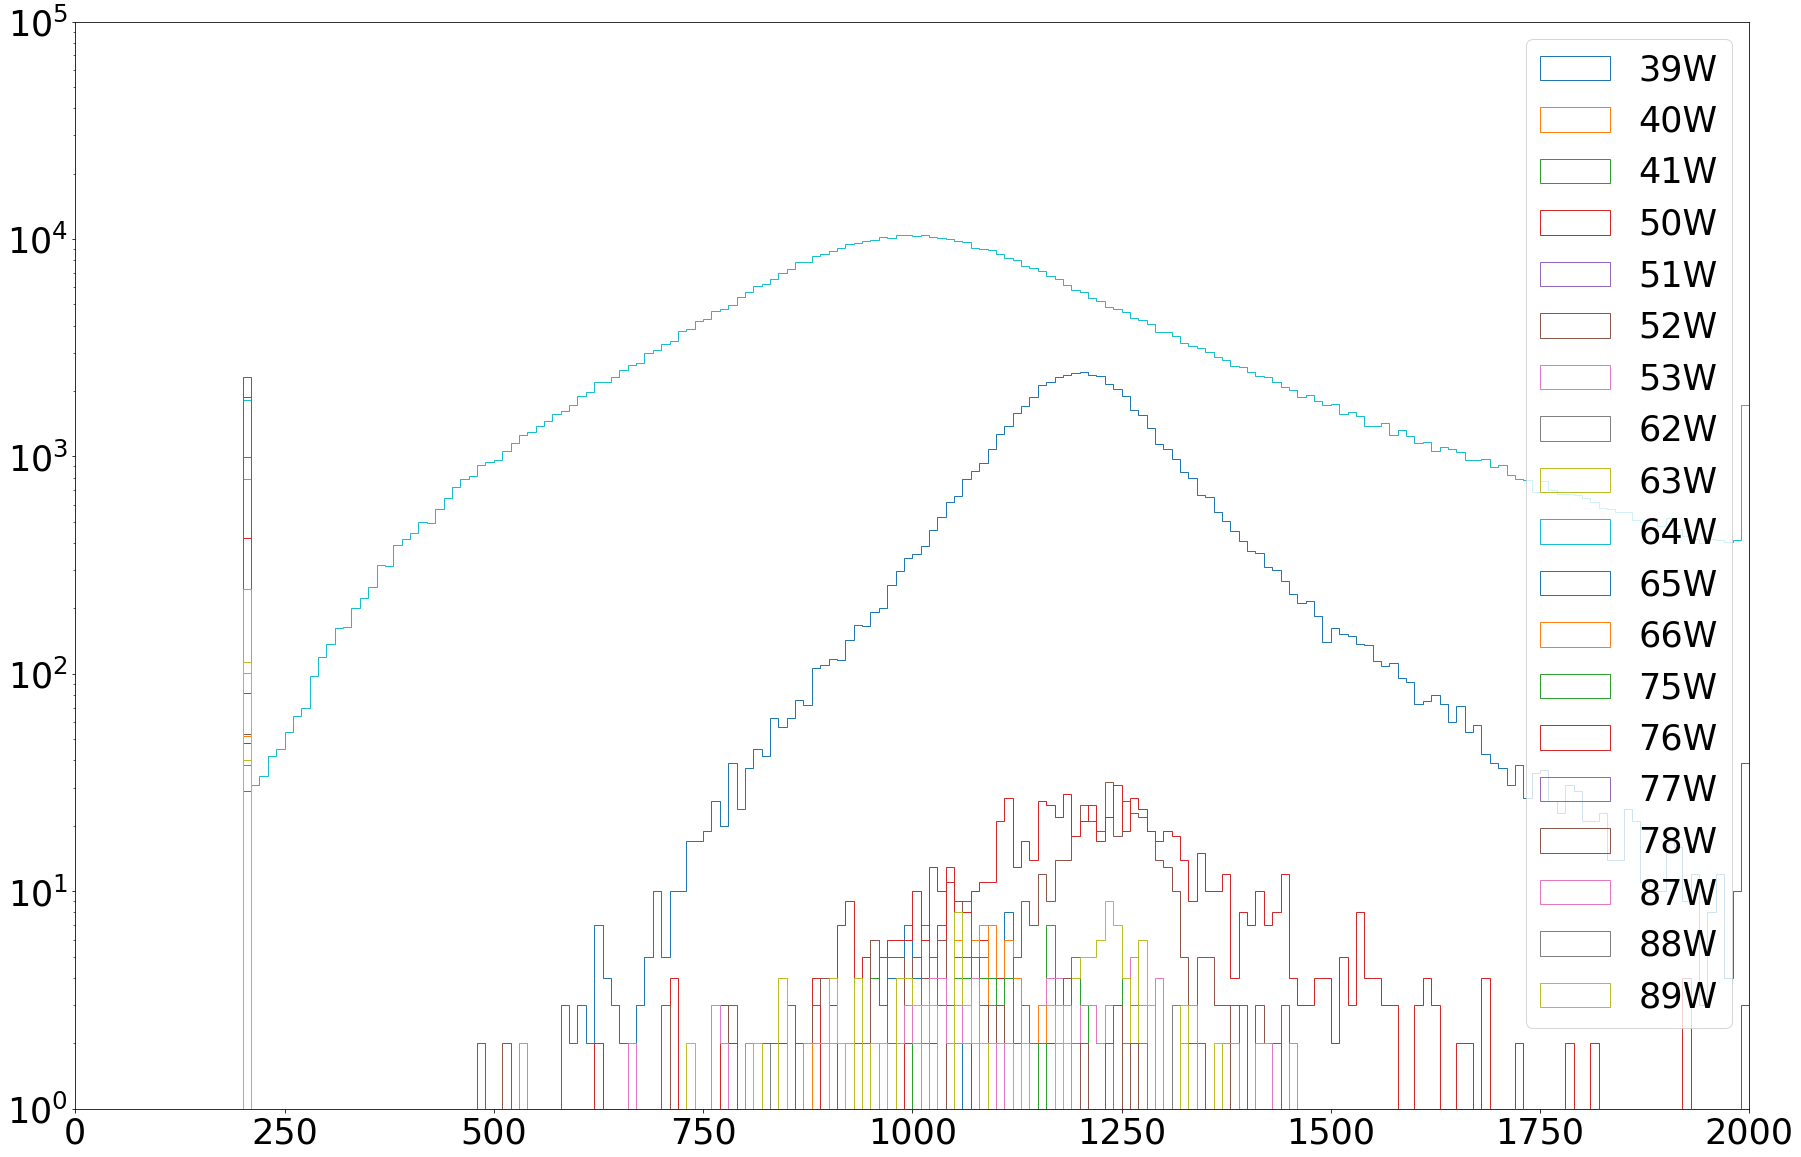

In [37]:
p=data[np.logical_and(data['energy']>200,data['energy']<2000)]
fs=35
figure(figsize=(30,20))

for i in range(1,42):
    bd,ch=int(i/8),int(i%8)
    if pd.pixel(bd,ch) == 'Psr' or pd.pixel(bd,ch) == 'N/A':
        continue

    #if i == 11 or i==12 or i==35:
    if i < 24:
        a,b,c=hist(pd.single_pixel(p,bd,ch)['falltime'],bins=500,\
                   range=[0,5000],histtype='step',label=pd.pixel(bd,ch))
#    a,b=np.histogram(pd.single_pixel(multi,bd,ch)['falltime'],bins=500,range=[0,5000])
#    d,e=np.histogram(pd.single_pixel(pulser,bd,ch)['falltime'],bins=500,range=[0,5000])
    print(int(b[np.argmax(a)]-e[np.argmax(d)]),pd.pixel(bd,ch))

legend(fontsize=fs)
tick_params(labelsize=fs)
xlim(0,2000)
ylim(1,1e5)
yscale('log')
show()